# Model Tests

Repo: https://github.com/qubvel/segmentation_models.pytorch

Models: https://smp.readthedocs.io/en/latest/models.html#unet

# Imports

In [1]:
from segmentation.helper_functions.data_functions import prep_dataloader

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


# Create Segmentation Model

In [3]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
    activation='softmax'
)

preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet18', pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\s2137314/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Loading Data

In [4]:
dir_img = 'C:/2022_Summer_Intern/Gel_Images_UNet_Test/Images_all_nathan+selected'
dir_mask = 'C:/2022_Summer_Intern/Gel_Images_UNet_Test/Masks_all_nathan+selected'
n_channels = 1
img_scale = 0.5
val_percent = 0.1
batch_size = 1
num_workers = 1

In [5]:
train_loader, val_loader, n_train, n_val = prep_dataloader(dir_img, 
                                                           dir_mask, 
                                                           n_channels, 
                                                           img_scale, 
                                                           val_percent, 
                                                           batch_size, 
                                                           num_workers)

# Do we need augmentation?

In [12]:
import matplotlib.pyplot as plt
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


(1024, 1360)


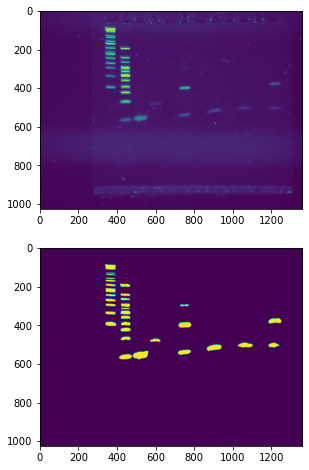

In [19]:
import albumentations as A
import imageio
import cv2
from PIL import Image
import numpy as np

image_file = "C:/2022_Summer_Intern/Gel_Images_UNet_Test/Final_Set/Training_Set/Images/066.tif"
mask_file = "C:/2022_Summer_Intern/Gel_Images_UNet_Test/Final_Set/Training_Set/Masks/066.tif"

max_height = 0
max_width = 0

# Load Image
image = imageio.imread(image_file)
if image.shape[-1] == 3:  # Actual input: 3 channels
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
elif image.shape[-1] == 4: # Actual input: 4 channels
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    
if image.dtype == 'uint8':
    max_val = 255
elif image.dtype == 'uint16':
    max_val = 65535
image = image.astype(np.float32) / (max_val - 0)

height = image.shape[0]
width = image.shape[1]
max_height = max(height, max_height)
max_width = max(width, max_width)

# Load mask
pil_mask = Image.open(mask_file)
final_mask = np.array(pil_mask)
unique = np.unique(final_mask)
mask = np.array([[np.where(unique == i)[0][0] for i in j] for j in final_mask])
print(mask.shape)

visualize(image, mask)

In [24]:
# Padding
def get_augmentation():
    min_height = 16*(max_height//16 + 1)
    min_width = 16*(max_width // 16 + 1)
    aug = [
        A.PadIfNeeded(min_height=min_height, min_width=min_width, value=0)
    ]
    return A.compose(aug)

In [23]:
from torch.utils.data import Dataset
class BasicDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, n_channels: int, 
                 augmentation=None, scale: float = 1.0, mask_suffix: str = ''):
        """
        TODO: fill in!
        :param images_dir:
        :param masks_dir:
        :param n_channels:
        :param scale:
        :param mask_suffix:
        """
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        assert (n_channels == 1 or n_channels == 3), 'Number of channels must be either 1 or 3'
        self.n_channels = n_channels
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix
        self.standard_image_transform = transforms.Compose([transforms.ToTensor()])

        self.image_names = extract_image_names_from_folder(images_dir)
        self.mask_names = extract_image_names_from_folder(masks_dir)
        self.masks_dict = {os.path.basename(mask).split('.')[0]: mask for mask in self.mask_names}

        self.augmentation = augmentation
        self.max_height = 0
        self.max_width = 0

        if not self.image_names:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')
        if not self.mask_names:
            raise RuntimeError(f'No input file found in {masks_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.image_names)} examples')

    def __len__(self):
        return len(self.image_names)


    @staticmethod
    def load_image(self, filename, n_channels):
        image = imageio.imread(filename)

        # Converting to desired number of channels
        if n_channels == 1:  # Target input: 1 channel
            if image.shape[-1] == 3:  # Actual input: 3 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            elif image.shape[-1] == 4: # Actual input: 4 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
            # No change required for already grayscale images
            height = image.shape[0]
            width = image.shape[1]
            self.max_height = max(height, self.max_height)
            self.max_width = max(width, self.max_width)
        elif n_channels == 3:  # Target input: 3 channels
            if image.shaoe[-1] == 4:  # Actual input: 4 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            elif image.shape[-1] != 3:  # Actual input: 1 channels
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)


        # Normalizing image
        if image.dtype == 'uint8':
            max_val = 255
        elif image.dtype == 'uint16':
            max_val = 65535
        image = image.astype(np.float32) / (max_val - 0)

        return self.standard_image_transform(image)

    @staticmethod
    def load_mask(filename):
        pil_mask = Image.open(filename)
        final_mask = np.array(pil_mask)
        unique = np.unique(final_mask)
        final_mask = np.array([[np.where(unique == i)[0][0] for i in j] for j in final_mask])
        return torch.from_numpy(final_mask)

# in your init function - run glob on the dataset folder, this gets all images and puts them in a list
    #2 when you get your id in __getitem__, just index the above list

    def __getitem__(self, idx):

        img_file = self.image_names[idx]
        mask_file = self.masks_dict[os.path.basename(img_file).split('.')[0]]

        if os.path.basename(img_file).split('.')[0] != os.path.basename(mask_file).split('.')[0]:
            raise RuntimeError('Gel and Mask images do not match')

        img_tensor = self.load_image(self, filename=img_file, n_channels=self.n_channels)
        mask_tensor = self.load_mask(mask_file)

        assert img_tensor.size(dim=-2) == mask_tensor.size(dim=-2) and \
               img_tensor.size(dim=-1) == mask_tensor.size(dim=-1), \
            f'Image and mask should be the same size, but are {img_tensor.size} and {mask_tensor.size}'

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return {
            'image': img_tensor,
            'mask': mask_tensor.int().contiguous()  # TODO: why do we need this .contiguous() call?
        }


In [ ]:
augmented_dataset = Dataset(
    xx)

# Training

In [6]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

AttributeError: module 'segmentation_models_pytorch' has no attribute 'utils'

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')